# Pigpen PyTorch Example
by Joe Norton

In [46]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [47]:
import random
from PigpenDataset import PigpenDatasetClass


In [48]:
transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.5,), (0.5,))  # Example normalization
])

train_dataset = PigpenDatasetClass('data/train', transform=transform)
test_dataset = PigpenDatasetClass('data/test', transform=transform)
valid_dataset = PigpenDatasetClass('data/validation', transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=27, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=27, shuffle=False)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=27, shuffle=False)


In [49]:
len(train_dataset), len(test_dataset), len(valid_dataset)

(54000, 10800, 10800)

In [50]:
import torch.nn as nn
import torch.nn.functional as F

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

class EnhancedCNN(nn.Module):
    def __init__(self):
        super(EnhancedCNN, self).__init__()
        self.flatten = nn.Flatten()
        self.conv_relu_pool_stack = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding="same"), #layer 1
            nn.ReLU(),
            #nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.1),
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding="same"), #layer 2
            nn.ReLU(),
            #nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.2),
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding="same"), #layer 3
            nn.ReLU(),
            #nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.4)
        )

        # Adjust these sizes based on your actual output from convolutions
        self.linear_layers = nn.Sequential(
            nn.Linear(1152, 256),  # Adjust size according to output
            nn.ReLU(),
            nn.Linear(256, 28)  # 28 output classes
        )


    def forward(self, x):
        x = self.conv_relu_pool_stack(x)
        #print(x.size())
        x = self.flatten(x)
        x = self.linear_layers(x)
        return x


model = EnhancedCNN().to(device)
print(model)


Using cuda device
EnhancedCNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (conv_relu_pool_stack): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.1, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.2, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout2d(p=0.4, inplace=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=1152, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=28, bias=True)
  )
)


In [51]:

# Create the network, define a loss function, and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


In [52]:
for X, y in test_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([27, 1, 28, 28])
Shape of y: torch.Size([27]) torch.int64


In [53]:
#stat accumulators
epoch_val_loss = []
epoch_val_acc = []

In [54]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [55]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    epoch_val_loss.append(test_loss)
    epoch_val_acc.append((100*correct))

In [56]:
epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    test(valid_loader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 3.331408  [   27/54000]
loss: 3.318384  [ 2727/54000]
loss: 3.232740  [ 5427/54000]
loss: 1.411900  [ 8127/54000]
loss: 0.827595  [10827/54000]
loss: 0.422953  [13527/54000]
loss: 0.463190  [16227/54000]
loss: 0.144152  [18927/54000]
loss: 0.057315  [21627/54000]
loss: 0.061176  [24327/54000]
loss: 0.159678  [27027/54000]
loss: 0.177939  [29727/54000]
loss: 0.051086  [32427/54000]
loss: 0.085277  [35127/54000]
loss: 0.013352  [37827/54000]
loss: 0.004118  [40527/54000]
loss: 0.003048  [43227/54000]
loss: 0.151662  [45927/54000]
loss: 0.019248  [48627/54000]
loss: 0.008502  [51327/54000]
Test Error: 
 Accuracy: 92.5%, Avg loss: 0.252516 

Epoch 2
-------------------------------
loss: 0.023664  [   27/54000]
loss: 0.012488  [ 2727/54000]
loss: 0.102247  [ 5427/54000]
loss: 0.169494  [ 8127/54000]
loss: 0.002500  [10827/54000]
loss: 0.017828  [13527/54000]
loss: 0.001840  [16227/54000]
loss: 0.026073  [18927/54000]
loss: 0.101132  [21627/54000

<function matplotlib.pyplot.show(close=None, block=None)>

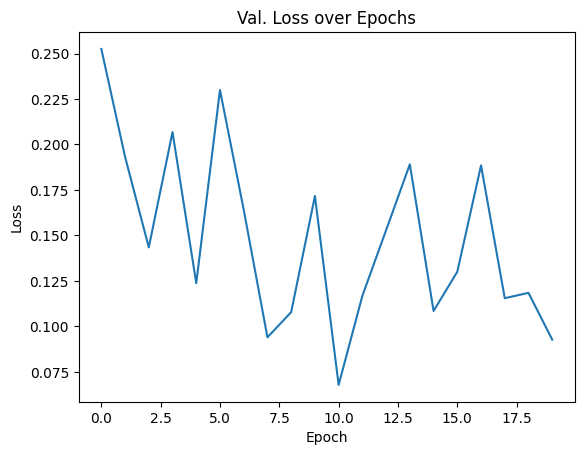

In [57]:
from matplotlib import pyplot as plt
plt.plot(epoch_val_loss, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Val. Loss over Epochs')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

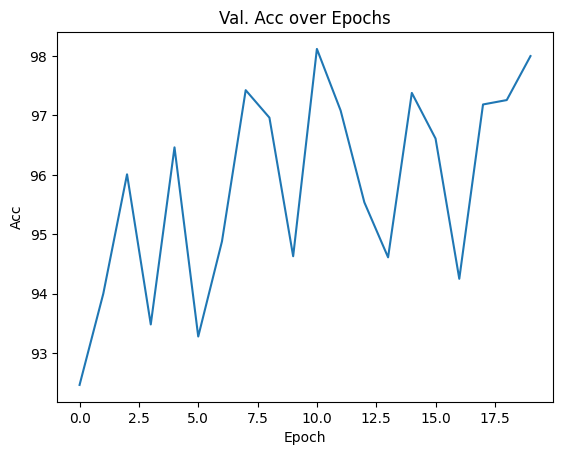

In [58]:
plt.plot(epoch_val_acc,label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Val. Acc over Epochs')
plt.show

In [59]:
test(test_loader, model, loss_fn)

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.090316 



In [60]:
'''
model_name = "enahncedcnn-conv-relu-bn-pool-do-adj"
torch.save(model.state_dict(), model_name + ".pth")
print(f"Saved PyTorch Model State to {model_name}.pth")
'''

'\nmodel_name = "enahncedcnn-conv-relu-bn-pool-do-adj"\ntorch.save(model.state_dict(), model_name + ".pth")\nprint(f"Saved PyTorch Model State to {model_name}.pth")\n'